## Get for all the core spp the branchwater results
- Make a presence absense table for all SRAs
- Convert the BW output to a [sra, num_spp] df
- Use this


In [1]:
import pandas as pd
import glob 
import os
import matplotlib.pyplot as plt

In [2]:
# lets put all functions at the top so when running notebook they are ready to go
# combine bw output dfs and create counts for each SRA
def combine_branchwater_res(dfs):
    combined = pd.concat(dfs, ignore_index=True)
    combined = combined[combined['organism'] != 'NP']
    combined = combined[combined['assay_type'] == 'WGS']

    result = (
        combined
        .value_counts(['acc', 'organism', 'bioproject'])
        .reset_index(name='count')
    )

    return result

# change format for df
def pivot_count(df):
    df_pivot = pd.crosstab(df['organism'], df['count']).reset_index()
    df_pivot.columns = ['organism'] + [str(col) for col in df_pivot.columns[1:]]
    return df_pivot

# SAME BUT SIMPLE
category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa']}


# Function to assign category based on keywords
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  # default if no keywords match

def group_for_plot(df):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    df_grouped = df.groupby('broad_cat')[numeric_cols].sum().reset_index()
    df_cumulative = df_grouped.copy()
    df_cumulative[numeric_cols] = df_cumulative[numeric_cols].iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1]
    return df_grouped, df_cumulative

# plot the numbers
def plot_cat(df):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    df_abs = df.set_index('broad_cat')[numeric_cols]
    ax = df_abs.T.plot(kind='bar', stacked=True, figsize=(5,5), color=[colors[c] for c in df_abs.index])
    ax.set_ylabel('Number of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 20)')
    plt.legend(title='Metagenome origin', loc='upper right')
    plt.tight_layout()

# plot rel percentages
def plot_cat_percent(df):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100

    # Plot stacked bar chart
    ax = df_norm.T.plot(kind='bar', stacked=True, figsize=(6,6), color=[colors[c] for c in df_norm.index])
    ax.set_ylabel('Percent of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 20)')
    plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()

# we saw the following when only comparing annotaded metagenomes...
def remove_unnannotated(df):
    df = df[df["organism"] != "metagenome"]
    df = df[df["organism"] != "gut metagenome"]
    df = df[df["organism"] != "feces metagenome"]
    df = df[df["organism"] != "manure metagenome"]
    df = df[df["organism"] != "bacterium"]
    df = df[df["organism"] != "unidentified"]
    return df


In [3]:
# set the branchwater files
files = glob.glob("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/*gtdb+mags.k21.csv")

In [4]:
# get df with counts of organism for each SRA 
dfs = [pd.read_csv(f, usecols=['acc', 'organism', 'assay_type', 'bioproject', 'cANI', 'containment']) for f in files]
df = combine_branchwater_res(dfs)


In [20]:
df['cANI'].value_counts()

cANI
0.93    13823
0.94    13797
0.92    12725
0.95    12381
0.91    11050
0.96     9560
0.90     8265
0.97     5319
0.98      843
Name: count, dtype: int64

In [17]:
# man check cows
df = df[df["organism"] == "pig gut metagenome"]


In [13]:
df.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/csv_files/251113_cow_PRJNA356291.csv')

## Compare only annotated metagenomes:

What is not annotated (not even an indication of an organism):
"metagenome", 
"gut metagenome", 

In [49]:
df = remove_unnannotated(df)    


In [50]:
dfp = pivot_count(df)

# get categories
dfp['broad_cat'] = dfp['organism'].apply(get_broad_cat_simple)
# get individual and cumulative dfs
df_ind, df_cm = group_for_plot(dfp)

print(len(df))

79812


In [51]:
df_cm.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251112_gtdb_mag_cumulative.csv', index=False)

In [28]:
# colormap plotting
colors = {
    'pig': '#264653',
    'human associated': '#e76f51',
    'other': '#f4a261',
    'pig/other': '#2a9d8f',
    'pig-associated': '#e9c46a'
    }

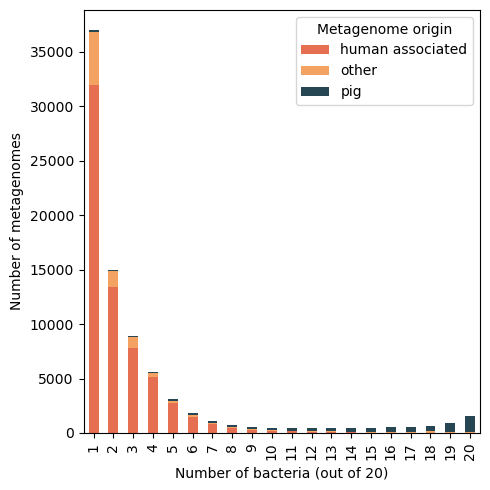

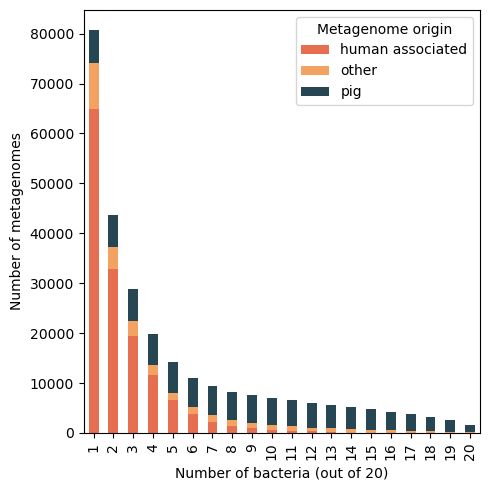

In [29]:
# make chart with absolute numbers
plot_cat(df_ind)
plot_cat(df_cm)

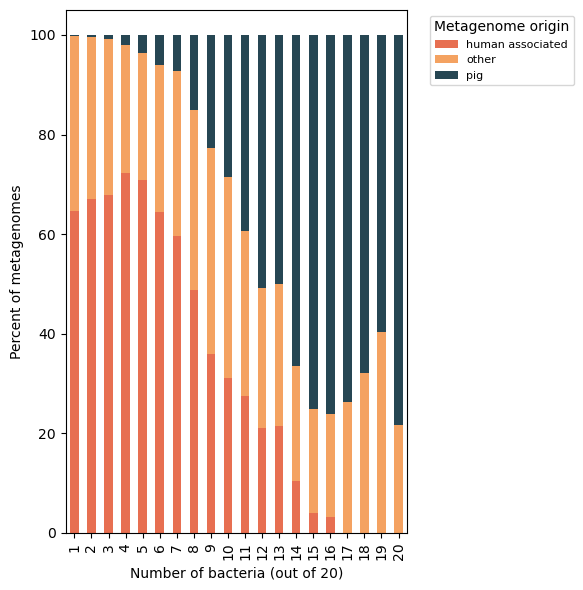

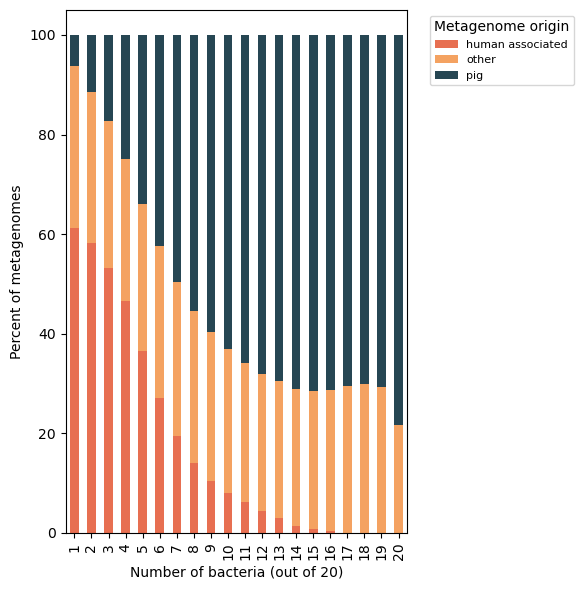

In [21]:
# Plot in percentages
plot_cat_percent(df_ind)
plot_cat_percent(df_cm)

## Do some manual curation on metadata:
- Many samples logged as "metagenome" or "gut metagenome" 
- Are theys in actuality pig?
- Move everything with the tag 'other' and look at the SRAs

In [65]:
# get the results to a df that i can manually curate
df['broad_cat'] = df['organism'].apply(get_broad_cat_simple)

# what is classified as other
other_mg = df[df['broad_cat'] == 'other']
other_mg.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251111_metag_other.branchwater.csv')


# how many times each bioproject wit what average count
counts_bp = (
    other_mg
    .groupby(['bioproject', 'organism', 'broad_cat'], as_index=False)
    .agg(
        avg_count=('count', 'mean'),
        bioproject_total=('bioproject', 'count')  # how many rows that bioproject has
    )
    .sort_values('avg_count', ascending=False)
)

counts_bp.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251112_metag_other.bioPcounts.excunan.csv')

In [55]:
# load mancur
df_mancur = pd.read_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251111_metag_mancur.csv')

In [56]:
# merge mancur with original df
df2 = df.merge(df_mancur[['bioproject', 'manual_org']], on='bioproject',how='left')
df2['organism'] = df2['manual_org'].combine_first(df2['organism'])
df2 = df2.drop(columns=['manual_org'])


In [59]:
dfp_mancur = pivot_count(df2)
dfp_mancur['broad_cat'] = dfp_mancur['organism'].apply(get_broad_cat_simple)
dfp_mancur.loc[dfp_mancur['organism'].str.lower() == 'pig-associated', 'broad_cat'] = 'pig-associated'
dfp_mancur.loc[dfp_mancur['organism'].str.lower() == 'pig/other', 'broad_cat'] = 'pig/other'


In [61]:
df_ind_mancur, df_cm_mancur = group_for_plot(dfp_mancur)

In [62]:
df_cm_mancur

,broad_cat,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,human associated,64896,32853,19464,11691,6554,3795,2286,1442,969,...,486,319,210,91,41,20,0,0,0,0
1,other,7609,3679,2345,1344,1044,863,739,638,546,...,386,342,302,239,203,164,133,104,63,23
2,pig,6575,6426,6328,6241,6090,5947,5810,5706,5560,...,5196,4958,4695,4418,4102,3704,3234,2791,2289,1482
3,pig-associated,309,248,200,193,187,185,178,173,171,...,160,157,150,147,142,132,119,102,90,60
4,pig/other,423,304,278,243,223,220,206,205,204,...,200,197,192,190,189,183,169,119,18,1


In [14]:
df_cm_mancur.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251111_metag_broadcat_mancur.branchwater.csv', index=False)

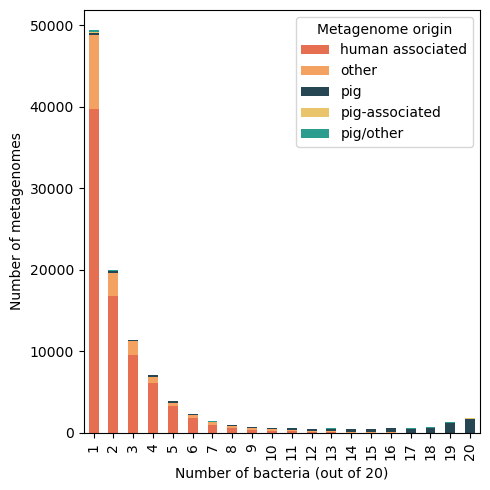

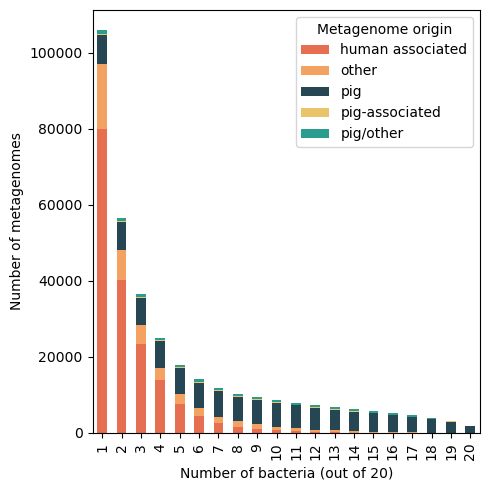

In [26]:
plot_cat(df_ind_mancur)
plot_cat(df_cm_mancur)

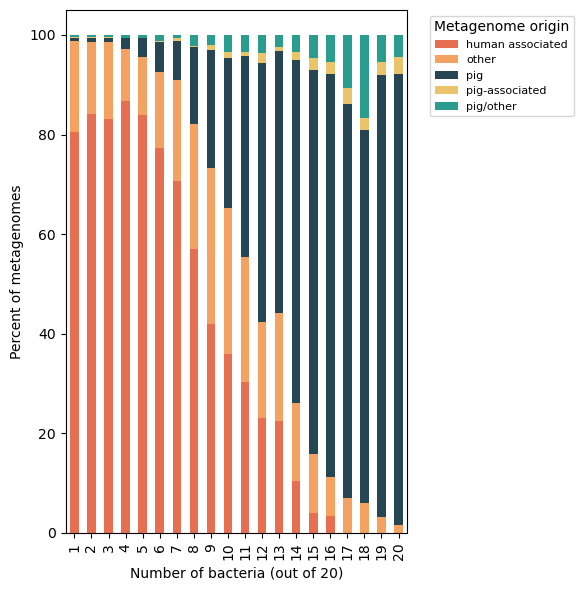

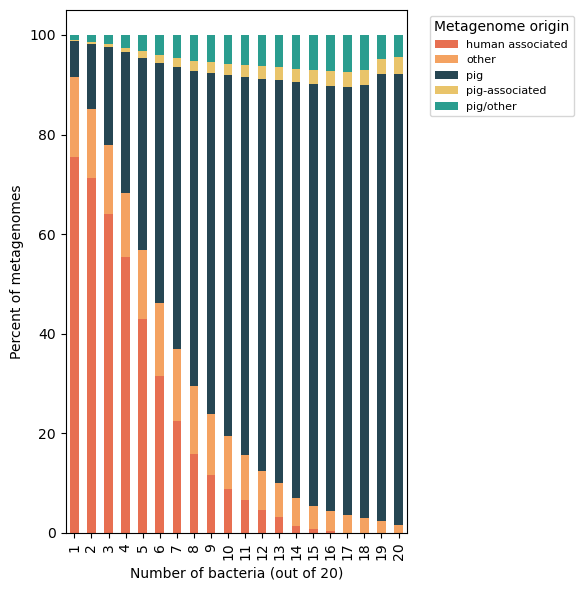

In [27]:
# pig/other being datasets labeled as "pig OR chicken", "pig OR cow", "metagenomes from various hosts (pig, human chicken)"
# because i am not going to look at each sample
# pig associated are datasets labeled as "pig manure in bioreactor", "clothing from person in swine facility", "stable floor"
plot_cat_percent(df_ind_mancur)
plot_cat_percent(df_cm_mancur)

## Same but now for branchwater with just GTDB
- Ran with GTDB pangenomes
- Exclude pig specific content:

- Do we get less matches?


While just the GTDB genomes yield more matches overall. 

In [52]:
# set the branchwater files
files = glob.glob("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/*.gtdb.k21.csv")

# get df with counts of organism for each SRA 
dfs = [pd.read_csv(f, usecols=['acc', 'organism', 'assay_type', 'bioproject']) for f in files]
df_gtdb = combine_branchwater_res(dfs)

In [53]:

df_gtdb = remove_unnannotated(df_gtdb)

In [54]:

dfp_gtdb = pivot_count(df_gtdb)

dfp_gtdb['broad_cat'] = dfp_gtdb['organism'].apply(get_broad_cat_simple)

df_ind_gtdb, df_cm_gtdb = group_for_plot(dfp_gtdb)

len(df_gtdb)

88781

In [45]:
df_cm_gtdb.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251112_gtdb_only_cumulative.csv')
df_cm.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/251112_gtdb_mag_cumulative.csv')

In [82]:
df_cm


,broad_cat,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,human associated,64816,32842,19461,11690,6554,3795,2286,1442,969,...,486,319,210,91,41,20,0,0,0,0
1,other,34483,17208,10723,7120,5295,4301,3611,3143,2792,...,2205,2004,1859,1701,1591,1480,1353,1194,955,409
2,pig,6581,6434,6338,6251,6102,5959,5819,5716,5570,...,5206,4968,4705,4428,4112,3714,3244,2798,2294,1485


In [83]:
df_cm_gtdb

,broad_cat,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,human associated,72540,36169,18279,8482,4163,2397,1446,903,578,...,247,127,62,31,0,0,0,0,0,0
1,other,39574,18828,10829,6124,4483,3684,3154,2789,2418,...,1844,1683,1539,1428,1292,1130,946,767,418,245
2,pig,6621,6459,6345,6242,6090,5915,5743,5583,5356,...,4883,4616,4234,3872,3382,2860,2262,1808,1265,597


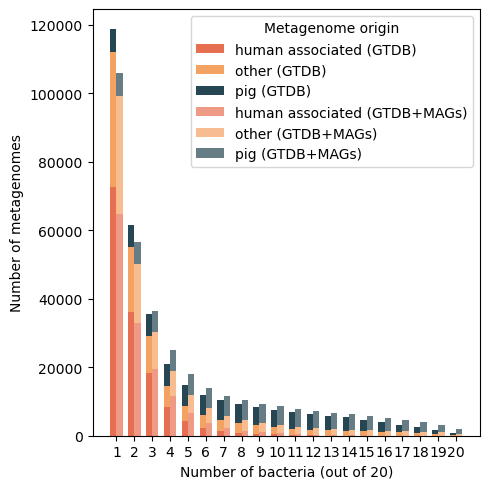

In [75]:
# Plot GTDB and GTDB + MAGs side by side 
plot_cat_side_by_side(df_cm_gtdb, df_cm, colors)


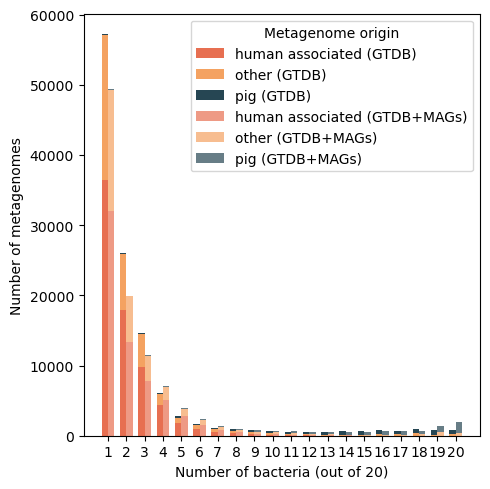

In [76]:
# Plot GTDB and GTDB + MAGs side by side  (not cumulative)
plot_cat_side_by_side(df_ind_gtdb, df_ind, colors)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_cat_side_by_side(df1, df2, colors, label1='GTDB', label2='GTDB+MAGs', figsize=(5,5)):
    # numeric columns
    numeric_cols = df1.select_dtypes(include='number').columns.tolist()
    
    # set broad_cat as index and transpose so numeric cols are x-axis
    df1_abs = df1.set_index('broad_cat')[numeric_cols].T
    df2_abs = df2.set_index('broad_cat')[numeric_cols].T
    
    # make sure both have the same x order
    shared_cols = df1_abs.index.intersection(df2_abs.index)
    df1_abs, df2_abs = df1_abs.loc[shared_cols], df2_abs.loc[shared_cols]
    
    # positions for bars
    x = np.arange(len(shared_cols))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # plot first dataframe (stacked)
    bottom = np.zeros(len(x))
    for cat in df1_abs.columns:
        ax.bar(x - width/2, df1_abs[cat], width, bottom=bottom,
               label=f'{cat} ({label1})',
               color=colors.get(cat, None))
        bottom += df1_abs[cat].values
    
    # plot second dataframe (stacked)
    bottom = np.zeros(len(x))
    for cat in df2_abs.columns:
        ax.bar(x + width/2, df2_abs[cat], width, bottom=bottom,
               label=f'{cat} ({label2})',
               color=colors.get(cat, None), alpha=0.7)
        bottom += df2_abs[cat].values
    
    ax.set_xticks(x)
    ax.set_xticklabels(shared_cols)
    ax.set_xlabel('Number of bacteria (out of 20)')
    ax.set_ylabel('Number of metagenomes')
    ax.legend(loc='upper right', title='Metagenome origin')
    plt.tight_layout()
    plt.show()


In [34]:
# can we threshold on cANI and containment 


def combine_branchwater_res(dfs):
    combined = pd.concat(dfs, ignore_index=True)
    combined = combined[combined['organism'] != 'NP']
    combined = combined[combined['assay_type'] == 'WGS']
    return combined

dfs = [pd.read_csv(f, usecols=['acc', 'organism', 'assay_type', 'bioproject', 'cANI', 'containment']) for f in files]
df = combine_branchwater_res(dfs)

In [10]:
#df = df[df["organism"] != "metagenome"]
df['containment'].mean()

np.float64(0.19945660121985143)

In [40]:
# df[df["organism"].str.contains(r"pig|sus|swine", case=False, na=False)].mean(numeric_only=True)
# df[df["organism"].str.contains(r"bovine|bos|cattle", case=False, na=False)].mean(numeric_only=True)
# df[df["organism"].str.contains(r"human|homo", case=False, na=False)].mean(numeric_only=True)

df = df[df["containment"] > 0.11]


In [39]:
df

,acc,assay_type,bioproject,cANI,containment,organism
0,SRR25936251,WGS,PRJNA1010706,0.93,0.23,pig gut metagenome
1,SRR11125486,WGS,PRJNA526405,0.94,0.26,pig gut metagenome
3,ERR1135387,WGS,PRJEB11755,0.96,0.42,pig gut metagenome
4,ERR3574843,WGS,PRJEB34634,0.95,0.35,sediment metagenome
5,ERR2241721,WGS,PRJEB22062,0.98,0.60,metagenome
...,...,...,...,...,...,...
382583,SRR11183331,WGS,PRJNA526405,0.90,0.12,pig gut metagenome
382584,SRR8960495,WGS,PRJNA526405,0.92,0.18,pig gut metagenome
382585,SRR11126015,WGS,PRJNA526405,0.92,0.18,pig gut metagenome
382586,SRR8960878,WGS,PRJNA526405,0.97,0.48,pig gut metagenome


In [41]:
def sum_n_org(df):
    result = (
        df.value_counts(['acc', 'organism', 'bioproject']).reset_index(name='count')
    )
    return result

In [42]:
df_sum = sum_n_org(df)

In [43]:
# 1485, 809, 504
df_sum[df_sum["organism"].str.contains(r"pig|sus|swine", case=False, na=False)]["count"].value_counts()


count
20    1197
19     661
18     468
17     460
15     415
16     412
14     348
13     318
12     315
9      265
11     251
10     217
4      188
8      179
5      171
1      165
7      138
6      130
3      120
2      120
Name: count, dtype: int64

In [44]:
# 21, 19, 19
df_sum[df_sum["organism"].str.contains(r"bovine|bos|cattle", case=False, na=False)]["count"].value_counts()


count
1     304
2      72
3      30
17     25
8      23
6      18
7      17
4      15
15     14
9      14
18     13
5      13
10     11
19     10
16      9
13      9
11      9
12      2
14      2
Name: count, dtype: int64

In [38]:
df_sum[df_sum["organism"].str.contains(r"Human|homo", case=False, na=False)]["count"].value_counts()


count
1     31974
2     13381
3      7771
4      5136
5      2759
6      1509
7       844
8       473
9       277
10      206
11      167
13      119
12      109
14       50
15       21
16       20
Name: count, dtype: int64